In [5]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [ "{:08b}".format(int(el, base=16)) for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [ "{:02x}".format(int(el, 2)) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

# Zadanie 1

In [3]:
message = "Tajna wiadomość"
message = encode_as_binary_array(message)

image = load_image("images/rembrandt.png")
image_with_message = hide_message(image, message, 1)

save_image("images/image_zad1_msg.png", image_with_message)
image_with_message = load_image("images/image_zad1_msg.png")

secret_message = decode_from_binary_array(
    reveal_message(image_with_message, nbits=1, length=len(message)))

print(secret_message)

Tajna wiadomość


# Zadanie 2

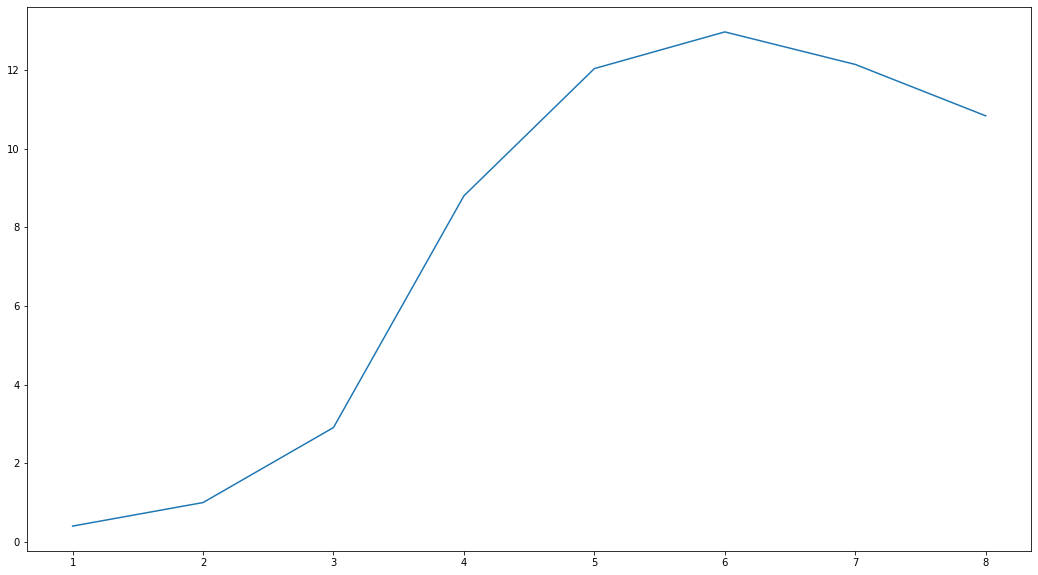

In [4]:
from lorem.text import TextLorem

lorem = TextLorem(srange=(1,1))

image = load_image("images/rembrandt.png")
word = lorem.sentence()
length = image.size // int(((5 * len(word) * 8) / 4))
message = word * length
msg = encode_as_binary_array(message)
MSE_list = []

for nbits in range(1, 9):
    image_with_message = hide_message(image, msg, nbits)
    differences = np.subtract(image, image_with_message)
    squared_differences = np.square(differences)
    MSE = squared_differences.mean()
    MSE_list.append(MSE)
    
plt.plot([i for i in range(1, 9)], [MSE_value for MSE_value in MSE_list])

# Zadanie 3

In [5]:
def hide_message(image, message, nbits=1, spos=0):
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        pos = i + spos
        byte = "{:08b}".format(image[pos])
        new_byte = byte[:-nbits] + chunk
        image[pos] = int(new_byte, 2)
        
    return image.reshape(shape)

def reveal_message(image, nbits=1, length=0, spos=0):
    nbits = clamp(nbits, 1, 8)
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image) - spos
    
    message = ""
    i = spos
    while i < length_in_pixels + spos:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message


In [6]:
nbits = 4
spos = 16

message = "Druga tajna wiadomość"
message = encode_as_binary_array(message)

image = load_image("images/rembrandt.png")
image_with_message = hide_message(image, message, nbits, spos)

save_image("images/image_zad3_msg.png", image_with_message)
image_with_message = load_image("images/image_zad3_msg.png")

secret_message = decode_from_binary_array(
    reveal_message(image_with_message, nbits, len(message), spos))

print(secret_message)

Druga tajna wiadomość


# Zadanie 4

In [7]:
# Pomocnicze funkcje
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = ["{:08b}".format(int(el, base=16)) for el in secret_img]
    secret_img = "".join(secret_img)
    return hide_message(image, secret_img, nbits), len(secret_img)

def reveal_message(image, nbits=1, length=0, spos=0):
    nbits = clamp(nbits, 1, 8)
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image) - spos
    
    message = ""
    i = spos
    while i < length_in_pixels + spos:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

In [8]:
def reveal_image(image, length=0, nbits=1):
    binary_img = reveal_message(image, nbits, length)
    binary_img = [binary_img[i:i+8] for i in range(0, len(binary_img), 8)]
    if len(binary_img[-1]) != 8:
        binary_img[-1] = binary_img[-1] + "0" * (8 - len(binary_img[-1]))
    binary_img = [ "{:02x}".format(int(el, 2)) for el in binary_img]
    binary_img = "".join(binary_img)
    binary_img = binascii.unhexlify(binary_img)
    return binary_img

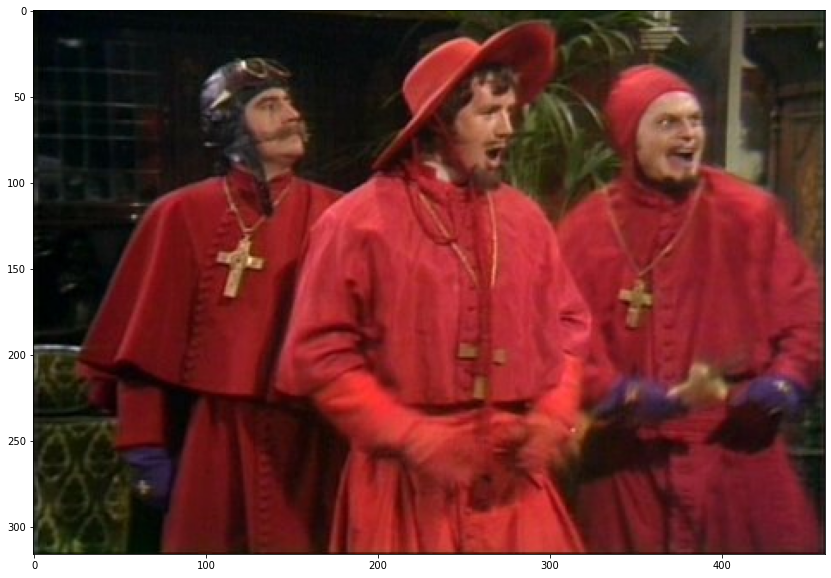

In [9]:
image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.png")
decoded = reveal_image(image_with_secret, length_of_secret)
with open("images/secret.png", "wb") as file:
        file.write(decoded)
decoded = load_image("images/secret.png")

plt.imshow(decoded)

# Zadanie 5

In [19]:
def reveal_message(image, nbits=1, spos=0):
    nbits = clamp(nbits, 1, 8)
    image = np.copy(image).flatten()

    message = ""
    i = spos
    while (message[-32:-24]) != "{:08b}".format(ord('I')) or\
            message[-24:-16] != "{:08b}".format(ord('E')) or\
            message[-16:-8] != "{:08b}".format(ord('N')) or\
            message[-8:] != "{:08b}".format(ord('D')):
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
    for j in range(32):
        byte = "{:08b}".format(image[j + i])
        message += byte[-nbits:]

    return message


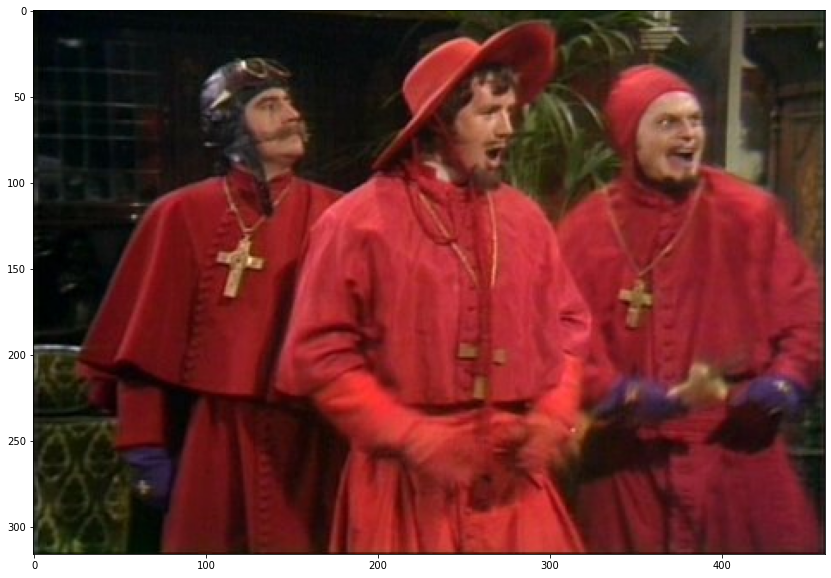

In [20]:

def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = ["{:08b}".format(int(el, base=16)) for el in secret_img]
    secret_img = "".join(secret_img)
    return hide_message(image, secret_img, nbits), len(secret_img)

def reveal_img(image, nbits=1):
    binary_img = reveal_message(image, nbits=nbits)
    binary_img = [binary_img[i:i+8] for i in range(0, len(binary_img), 8)]
    if len(binary_img[-1]) != 8:
        binary_img[-1] = binary_img[-1] + "0" * (8 - len(binary_img[-1]))
    binary_img = [ "{:02x}".format(int(el, 2)) for el in binary_img]
    binary_img = "".join(binary_img)
    binary_img = binascii.unhexlify(binary_img)
    return binary_img

image = load_image("images/rembrandt.png")
image_with_secret, length = hide_image(image, "images/spanish.png")
decoded = reveal_img(image_with_secret)

with open("images/secret2.png", "wb") as file:
        file.write(decoded)
decoded = load_image("images/secret2.png")
plt.imshow(decoded)